In [4]:
# !pip install pytorch-lightning
# !pip install transformers
# !pip install vncorenlp

In [5]:
# from google.colab import drive
# drive.mount("/content/drive")

In [6]:
!nvidia-smi

Mon May  9 23:00:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:5E:00.0 Off |                  N/A |
| 32%   53C    P2   132W / 250W |   6263MiB / 11019MiB |     27%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:86:00.0 Off |                  N/A |
|  0%   

In [7]:
# !kill -9 3980682

In [8]:
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
import zipfile
from PIL import Image
import matplotlib.pyplot as plt
import re
import pytorch_lightning as pl
from torchvision import transforms as T
from sklearn.model_selection import train_test_split

train_ratio = 0.8

/home/nghiatl/anaconda3/envs/AI_DA/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
import random

# SEED_VALUE = random.randint(0,100)
SEED_VALUE = 7
# print(SEED_VALUE)
random.seed(SEED_VALUE)
torch.manual_seed(SEED_VALUE)
torch.cuda.manual_seed(SEED_VALUE)
np.random.seed(SEED_VALUE)

In [10]:
# %cd /content/drive/MyDrive/Colab Notebooks/Multimodal

In [11]:
!ls
data_zip_file = './local1_folder.zip'
# data_zip_file2 = './local1_folder_temp.zip'

csv_file2 = './OUTPUT/Comment_22.csv'
csv_file3 = './OUTPUT/Comment_23.csv'
csv_file4 = './OUTPUT/Comment_24.csv'
csv_file5 = './OUTPUT/Comment_25.csv'

csv_file = './OUTPUT/Comment.csv'

archive.zip
Attetion-Multimodal-Bin2.ipynb
Attetion-Multimodal-Bin2-Moredata-Copy1.ipynb
Attetion-Multimodal-Bin2-Moredata.ipynb
Attetion-Multimodal-Bin.ipynb
Attetion-Multimodal.ipynb
Attetion-Multimodal-LateFusion-Copy1.ipynb
Attetion-Multimodal-LateFusion.ipynb
Attetion-Multimodal-seed25-1e-3-Copy1.ipynb
Attetion-Multimodal-seed25-1e-3.ipynb
Attetion-Multimodal-seed7.ipynb
Attetion-Multimodal-Soccer.ipynb
CNN.ipynb
Inception-Attetion-Copy1.ipynb
Inception-Attetion-Copy2.ipynb
Inception-Attetion.ipynb
Inception.ipynb
Inception-VotingMultimodal.ipynb
local1_folder_temp.zip
local1_folder.zip
mountains.zip
Multimodal_newmodel.ipynb
Multimodal_newmodel-weight.ipynb
my_checkpoint_attention_seed_84_1e-3_drop02.pth.tar
my_checkpoint_attention_seed_84_1e-3.pth.tar
my_checkpoint_attention_seed_84_f1_1e-3_drop02.pth.tar
my_checkpoint_attention_seed_84_f1_1e-3.pth.tar
my_checkpoint_attention_seed_84_f1.pth.tar
my_checkpoint_attention_seed_84.pth.tar
my_checkpoint_incept_attention_seed_84_1e-3_d

In [12]:
!nvidia-smi

Mon May  9 23:00:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:5E:00.0 Off |                  N/A |
|  0%   53C    P2    93W / 250W |   6263MiB / 11019MiB |     28%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:86:00.0 Off |                  N/A |
|  0%   

# Data preprocessing

## Image data

In [13]:
data_zip = zipfile.ZipFile(data_zip_file)

In [14]:
len(data_zip.namelist())

58766

In [15]:
'local1_folder-1/foody-fukunohana-hanoi-japanese-retstaurant-970-637197316556573205.jpg' in data_zip.namelist()

True

local1_folder-1/foody-fukunohana-hanoi-japanese-retstaurant-970-637197316556573205.jpg
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=800x734 at 0x7F14C6261DE0>
(734, 800, 3)


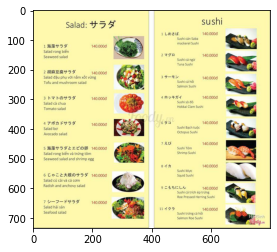

In [16]:
img_path = data_zip.namelist()[1]
print(img_path)
img = Image.open(data_zip.open(img_path))
print(img)
print(np.asarray(img).shape)
plt.imshow(img)

In [17]:
# ### Scale image to [0,1]
# trans = T.ToTensor()
# trans(img).shape

## CSV data

In [18]:
data_df1 = pd.read_csv(csv_file)
data_df2 = pd.read_csv(csv_file2)
data_df3 = pd.read_csv(csv_file3)
data_df4 = pd.read_csv(csv_file4)
data_df5 = pd.read_csv(csv_file5)


data_df1[['Comment', 'Rating']].head()

,Comment,Rating
0,Đặt dồi sụn của quán vì đọc comment thấy hấp d...,5.8
1,"Dồi khá ngon, mua về còn nóng mở ra thơm phức,...",9.0
2,"Đặt xuất mỳ trộn thập cẩm, khá đầy đủ và đầy đ...",9.4
3,Không hiểu sao quán này được 7.9 luôn. Đặt bán...,4.6
4,"Dồi sụn bé tẹo, giá quá cao so với các quán kh...",1.0


In [19]:
data_df4.shape

(3093, 11)

In [20]:
data_df = pd.concat([data_df1,data_df2,data_df3,data_df4, data_df5], ignore_index = True)

In [21]:
data_df.shape

(14174, 11)

In [22]:
data_df = data_df.dropna()
data_df = data_df.reset_index(drop=True)

In [23]:
data_df.isnull().sum()

RevId                   0
UserId                  0
ResId                   0
Comment                 0
image_urls              0
Food_score_cmt          0
Services_score_cmt      0
Atmosphere_score_cmt    0
Position_score_cmt      0
Price_score_cmt         0
Rating                  0
dtype: int64

In [24]:
## Add more data
data_df.rename(columns={"Rating":"score"}, inplace=True)
data_df.head()

,RevId,UserId,ResId,Comment,image_urls,Food_score_cmt,Services_score_cmt,Atmosphere_score_cmt,Position_score_cmt,Price_score_cmt,score
0,3648046,8920424,965165,Đặt dồi sụn của quán vì đọc comment thấy hấp d...,https://images.foody.vn/res/g97/965165/s800/fo...,5.0,9.0,5.0,5.0,5.0,5.8
1,3695359,18558601,965165,"Dồi khá ngon, mua về còn nóng mở ra thơm phức,...",https://images.foody.vn/res/g97/965165/s800/fo...,10.0,10.0,9.0,8.0,8.0,9.0
2,3695487,13885433,965165,"Đặt xuất mỳ trộn thập cẩm, khá đầy đủ và đầy đ...",https://images.foody.vn/res/g97/965165/s800/fo...,10.0,10.0,9.0,8.0,10.0,9.4
3,4256913,11400976,965165,Không hiểu sao quán này được 7.9 luôn. Đặt bán...,https://images.foody.vn/res/g97/965165/s800/fo...,1.0,5.0,5.0,6.0,6.0,4.6
4,4246644,525112,965165,"Dồi sụn bé tẹo, giá quá cao so với các quán kh...",https://images.foody.vn/res/g97/965165/s800/fo...,1.0,1.0,1.0,1.0,1.0,1.0


In [25]:
data_df['image_urls'][0]

'https://images.foody.vn/res/g97/965165/s800/foody-doi-sun-pate-shop-online-389-637116772226077520.jpg,https://images.foody.vn/res/g97/965165/s800/foody-doi-sun-pate-shop-online-427-637116772199356351.jpg'

In [26]:
# ## Calculate score
# data_df['score'] = data_df.apply(lambda x: (x['Food_score_cmt']+x['Services_score_cmt']+x['Atmosphere_score_cmt']+x['Position_score_cmt']+x['Price_score_cmt'])/5, axis = 1)
data_df[(data_df['score'] >= 8) & (data_df['score'] <= 8)][['Comment','score']].sort_values(by=['score'])

,Comment,score
8,Giữa cái thời tiết HN sớm trưa mưa nắng thất t...,8.0
9677,Sáng nào mình cx phải ăn phở ở đây ms chịu đc ...,8.0
9701,"Hàng xôi tấp nập người ghé ăn & mua mang đi, n...",8.0
9705,"Quán chè nhỏ nhỏ, đối diện bakery Tati. Cô chủ...",8.0
9713,❤ Vị trí : hàng này mới mở dạo gần đây. Nằm ng...,8.0
...,...,...
4892,* mùa dịch ăn gì ??🤔🤔\nĐang mùa dịch thế này c...,8.0
4907,Suất đặc biệt cơm gà + sườn ship Now,8.0
4955,Chè sầu chính hãng nè cả nhà 😻 viêm họng mà vẫ...,8.0
5034,"Nhân ngày xe bus hỏng đúng quán ding tea, mình...",8.0


In [27]:
data_df['Comment'][8]

'Giữa cái thời tiết HN sớm trưa mưa nắng thất thường, tối phần phật gió như này thì việc ngồi nhâm nhâm nhi nhi em caramen hoa quả này là 1 điều thật tuyệt - thơm thơm ngậy ngậy của caramen, vị thanh mát của các loại hoa quả: dưa hấu, xoài, thanh long, mít....được kết hợp lại với nhau rất thú vị, cốc còn rất là đầy đặn nữa chứ. Cơ mà anh chị chủ quán làm ngon quá đi, cứ bị nghiện ý, mỗi ngày sẽ nếm 1 vị: sữa chua thạch lá nếp nè, sc hoa quả, chè khoai dẻo nè.....chu choa v.v.....vân vân và mây mây...'

In [28]:
## label data
def label_comment(x):
  if x['score'] >= 8:
    return 1
  elif (x['score'] >= 6) & (x['score'] < 8):
    return 2
  else:
    return 0
data_df['label'] = data_df.apply(label_comment, axis=1)

In [29]:
data_df = data_df[data_df['label'] != 2]

1    6953
0    3023
Name: label, dtype: int64


<AxesSubplot:>

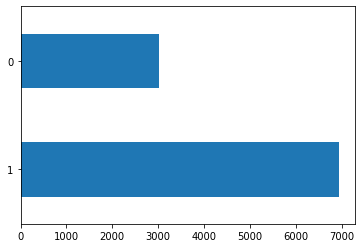

In [30]:
print(data_df['label'].value_counts())
data_df['label'].value_counts().plot(kind='barh')

In [31]:
data_df[['Comment','label', 'score']].head()

,Comment,label,score
0,Đặt dồi sụn của quán vì đọc comment thấy hấp d...,0,5.8
1,"Dồi khá ngon, mua về còn nóng mở ra thơm phức,...",1,9.0
2,"Đặt xuất mỳ trộn thập cẩm, khá đầy đủ và đầy đ...",1,9.4
3,Không hiểu sao quán này được 7.9 luôn. Đặt bán...,0,4.6
4,"Dồi sụn bé tẹo, giá quá cao so với các quán kh...",0,1.0


In [32]:
data_df = data_df.drop(['Food_score_cmt','Services_score_cmt','Atmosphere_score_cmt','Position_score_cmt','Price_score_cmt'],axis=1)
data_df.head()

,RevId,UserId,ResId,Comment,image_urls,score,label
0,3648046,8920424,965165,Đặt dồi sụn của quán vì đọc comment thấy hấp d...,https://images.foody.vn/res/g97/965165/s800/fo...,5.8,0
1,3695359,18558601,965165,"Dồi khá ngon, mua về còn nóng mở ra thơm phức,...",https://images.foody.vn/res/g97/965165/s800/fo...,9.0,1
2,3695487,13885433,965165,"Đặt xuất mỳ trộn thập cẩm, khá đầy đủ và đầy đ...",https://images.foody.vn/res/g97/965165/s800/fo...,9.4,1
3,4256913,11400976,965165,Không hiểu sao quán này được 7.9 luôn. Đặt bán...,https://images.foody.vn/res/g97/965165/s800/fo...,4.6,0
4,4246644,525112,965165,"Dồi sụn bé tẹo, giá quá cao so với các quán kh...",https://images.foody.vn/res/g97/965165/s800/fo...,1.0,0


In [33]:
def preprocess_imgpath(df):
    img_p = []
    for path in df['image_urls'].split(","):
        img_path = 'local1_folder-1/' + path.split('/')[-1]
        if img_path in data_zip.namelist():
            img_p.append(img_path)
    if len(img_p) > 0:
        return ','.join(img_p)
    return None

In [34]:
data_df['image_urls'] = data_df.apply(preprocess_imgpath, axis=1)

In [35]:
data_df = data_df.dropna()
data_df = data_df.reset_index(drop=True)
data_df.isnull().sum()

RevId         0
UserId        0
ResId         0
Comment       0
image_urls    0
score         0
label         0
dtype: int64

1    6952
0    3023
Name: label, dtype: int64


<AxesSubplot:>

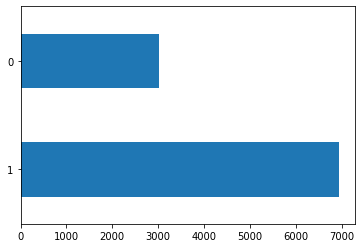

In [36]:
print(data_df['label'].value_counts())
data_df['label'].value_counts().plot(kind='barh')

In [37]:
def loaddicchar():
    dic = {}
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|đ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split(
        '|')
    charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|đ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split(
        '|')
    for i in range(len(char1252)):
        dic[char1252[i]] = charutf8[i]
    return dic
 
 
dicchar = loaddicchar()
 
# Đưa toàn bộ dữ liệu qua hàm này để chuẩn hóa lại
def convert_unicode(txt):
    return re.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|đ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dicchar[x.group()], txt)

In [38]:
from vncorenlp import VnCoreNLP
rdrsegmenter = VnCoreNLP("./vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m') 

uniChars = "àáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵÀÁẢÃẠÂẦẤẨẪẬĂẰẮẲẴẶÈÉẺẼẸÊỀẾỂỄỆĐÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴÂĂĐÔƠƯ"
punc_re = '[^\w'+uniChars+']'
def preprocess_text(sen):
  ##Unicode reform
  assert isinstance(sen, str), 'Not String'
  sen = convert_unicode(sen)
  ##Remove punctuation
  sen = re.sub(punc_re,' ', sen)
  ##Remove multiple space
  sen = re.sub('\s+',' ', sen)
  ##Lower
  sen = sen.lower()
  ##Segment
  seg = rdrsegmenter.tokenize(sen)
  if len(seg) == 0:
    sen = ' '
  else: 
    sen = ' '.join(seg[0])
  return sen
# vec_pre = np.vectorize(preprocess_text)
# print(vec_pre((data_df.iloc[3,3])))
data_df['preprocess_comment'] = data_df.apply(lambda x: preprocess_text(x['Comment']), axis = 1)

In [39]:
data_df.head()

,RevId,UserId,ResId,Comment,image_urls,score,label,preprocess_comment
0,3648046,8920424,965165,Đặt dồi sụn của quán vì đọc comment thấy hấp d...,local1_folder-1/foody-doi-sun-pate-shop-online...,5.8,0,đặt dồi sụn của quán vì đọc comment thấy hấp_d...
1,3695359,18558601,965165,"Dồi khá ngon, mua về còn nóng mở ra thơm phức,...",local1_folder-1/foody-doi-sun-pate-shop-online...,9.0,1,dồi khá ngon mua về còn nóng mở ra thơm_phức s...
2,3695487,13885433,965165,"Đặt xuất mỳ trộn thập cẩm, khá đầy đủ và đầy đ...",local1_folder-1/foody-doi-sun-pate-shop-online...,9.4,1,đặt xuất mỳ trộn thập_cẩm khá đầy_đủ và đầy_đặ...
3,4256913,11400976,965165,Không hiểu sao quán này được 7.9 luôn. Đặt bán...,local1_folder-1/foody-doi-sun-pate-shop-online...,4.6,0,không hiểu sao quán này được 7 9 luôn đặt bánh...
4,4246644,525112,965165,"Dồi sụn bé tẹo, giá quá cao so với các quán kh...",local1_folder-1/foody-doi-sun-pate-shop-online...,1.0,0,dồi sụn bé tẹo giá quá cao so với các quán khá...


In [40]:
data_df[data_df['preprocess_comment']==" "].shape
# data_df.drop(data_df[data_df['preprocess_comment']==" "].index, inplace = True)

(9, 8)

In [41]:
data_df = data_df.reset_index()
data_df['preprocess_comment'][4187:4191]

4187    vị_trí ở mặt đường nhưng ở cạnh quán mì cay to...
4188    thật tuyệt_cú mèo luôn mỗi cốc hoa_quả dầm ở đ...
4189    mình đã ăn_ở địa_điểm 211 chùa láng được hơn 1...
4190    nghe mọi người khen quán này dữ lém nên hôm_na...
Name: preprocess_comment, dtype: object

In [42]:
a = data_df['preprocess_comment'].str.split()
a = a.apply(lambda x: len(x))
a[a==1]

314     1
415     1
744     1
1011    1
1077    1
1543    1
1779    1
1808    1
1888    1
2302    1
2337    1
2528    1
2836    1
2873    1
2976    1
3489    1
3643    1
4328    1
4409    1
4645    1
5242    1
5564    1
5976    1
6341    1
6487    1
6748    1
7554    1
7603    1
8684    1
8881    1
9377    1
9523    1
Name: preprocess_comment, dtype: int64

In [43]:
a

0        56
1        43
2        38
3        34
4        74
       ... 
9970     42
9971     48
9972    107
9973    185
9974     17
Name: preprocess_comment, Length: 9975, dtype: int64

In [44]:
data_df['Comment'][195]

'Sữa chua mít + trà đào ngon, caramen trong sữa chua ăn cũng ok, giá vừa phải. Quán sạch sẽ, nhân viên phục vụ tốt. Sẽ quay lại.'

<AxesSubplot:>

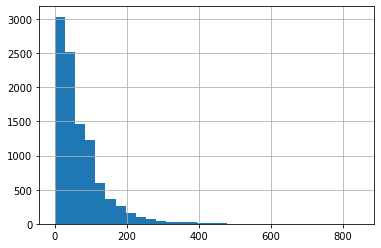

In [45]:
seq_len = [len(i.split()) for i in data_df['preprocess_comment']]

pd.Series(seq_len).hist(bins = 30)

<AxesSubplot:>

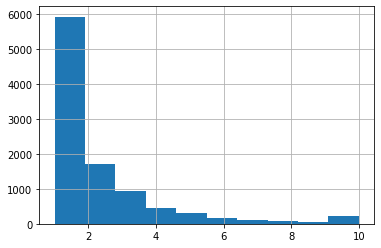

In [46]:
img_len = [len(i.split(',')) for i in data_df['image_urls']]

pd.Series(img_len).hist(bins = 10)

In [47]:
img_len = pd.DataFrame(img_len)
img_len.value_counts()

1     5930
2     1699
3      940
4      454
5      320
10     210
6      178
7      121
8       75
9       48
dtype: int64

In [48]:
img_len.mean()

0    2.066266
dtype: float64

# Load BPE, Vocab of PhoBERT and DataGen

In [49]:
from transformers import AutoModel, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [50]:
def collate_batch(batch):
  input_ids = []
  attention_masks = []
  imgs = []
  img_len = []
  labels = []
  for bt in batch:
    input_ids.append(bt[0]['input_ids'][0])
    attention_masks.append(bt[0]['attention_mask'][0])
    imgs.extend(bt[1])
    img_len.append(len(bt[1]))
    labels.append(bt[2])

  bert_tokens = torch.stack(input_ids)
  attention_masks = torch.stack(attention_masks)
  imgs_torch = torch.stack(imgs)
  labels = torch.LongTensor(labels)

  return  { 'input_ids': bert_tokens , 'attention_mask':attention_masks } , imgs_torch, img_len, labels

In [51]:
trans = T.ToTensor()
RANDOM_SEED = 0
MAX_LEN = 150


class SentimentData(Dataset):
  def __init__(self, data, transform = None):
    self.df = data.reset_index(drop=True)
    self.transform = transform
  def __len__(self):
    # print('Size',len(self.df))
    return len(self.df)  
  def __getitem__(self,idx):
    text = self.df["preprocess_comment"][idx]
    text = tokenizer(text, padding='max_length', truncation=True, max_length = MAX_LEN, return_tensors="pt")

    img_list = []
    for path in self.df['image_urls'][idx].split(","):
#       img_path = '/' + path.split('/')[-1]
      img = Image.open(data_zip.open(path))
      if self.transform is not None:
        img = self.transform(img)
      img_list.append(img)

    # print(text.shape)
    # text = ' '.join(text[0])
    label = self.df["label"][idx]

    return (text, img_list, label)

class SentimentDataModule(pl.LightningDataModule):
    
  def __init__(self, data, batch_size: int = 8, test_size = 0.2):
      super().__init__()
      self.test_size = test_size
      self.data = data
      self.batch_size = batch_size
      self.train_data = ''
      self.val_data = ''
      self.test_data = ''

  def prepare_data(self):
      self.train_data, self.val_data = train_test_split(self.data, test_size = self.test_size, random_state=RANDOM_SEED, stratify = self.data['label'])
      self.test_data, self.val_data = train_test_split(self.val_data,test_size = 0.5, random_state=RANDOM_SEED, stratify = self.val_data['label'])
      print(self.data['label'].value_counts())
      print(self.train_data['label'].value_counts())
      print(self.val_data['label'].value_counts())
      print(self.test_data['label'].value_counts())

  def setup(self, stage = None):
      train_transform = T.Compose([
       T.Resize([299, 299]), T.RandomHorizontalFlip(), T.RandomRotation(10),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
      ])
      val_transform = T.Compose([
        T.Resize([299, 299]), T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
      ])
      test_transform = T.Compose([
        T.Resize([299, 299]), T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
      ])
      self.train = SentimentData(self.train_data, train_transform)
      self.val = SentimentData(self.val_data, val_transform)
      self.test = SentimentData(self.test_data, test_transform)


  def train_dataloader(self):
      return DataLoader(self.train, batch_size=self.batch_size, shuffle=True, collate_fn=collate_batch)

  def val_dataloader(self):
      return DataLoader(self.val, batch_size=self.batch_size, collate_fn=collate_batch)

  def test_dataloader(self):
      return DataLoader(self.test, batch_size=self.batch_size, collate_fn=collate_batch)

  

In [52]:
# Do some Test with data
if __name__ == "__main__":
  dm = SentimentDataModule(data_df)
  dm.prepare_data()
  dm.setup()
  for step, bat in enumerate(dm.train_dataloader()):
    if step > 0: break
    print(step)
    print(bat[0]['input_ids'].shape)
    print(bat[1].shape)
    print(sum(bat[2]))
    print(len(bat[3]))

1    6952
0    3023
Name: label, dtype: int64
1    5562
0    2418
Name: label, dtype: int64
1    695
0    303
Name: label, dtype: int64
1    695
0    302
Name: label, dtype: int64
0
torch.Size([8, 150])
torch.Size([13, 3, 299, 299])
13
8


In [53]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

Computation device: cuda:1



# PhoBERT

In [54]:
from transformers import RobertaModel, RobertaConfig, AdamW, AutoModel
from transformers import RobertaForSequenceClassification

pretrained_config_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/config.json"
pretrained_model_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/model.bin"

In [55]:
# class Bert_Lstm(nn.Module):
#   def __init__(self):
#     super().__init__()
#     self.PhoBERT = AutoModel.from_pretrained("vinai/phobert-base")

#     self.lstm = nn.LSTM(input_size=768, hidden_size=128, num_layers= 1, batch_first=True)
  
#   def forward(self, texts):
#     bert_out = self.PhoBERT(texts['input_ids'],token_type_ids=None, attention_mask = texts['attention_mask'])
#     bert_out = bert_out['last_hidden_state']
#     out, _ = self.lstm(bert_out)
#     feature_extract = out[:,-1,:].contiguous()

#     return feature_extract

In [56]:
# # This time, the output's 2nd dimension is 3, indicating that there were 3 outputs given by the LSTM. 
# # This corresponds to the length of our input sequence. 
# # For the use cases where we'll need an output at every time step (many-to-many), such as Text Generation, the output of each time step can be extracted directly from the 2nd dimension and fed into a fully connected layer. 
# # For text classification tasks (many-to-one), such as Sentiment Analysis, the last output can be taken to be fed into a classifier.

# pho_test = Bert_Lstm()
# pho_test
# # oooo = pho_test('iiii')
# for name, child in pho_test.named_children():
#   print(name)

# InceptionV3

In [57]:
from torchvision.models import inception_v3

In [58]:
# class Inception(nn.Module):
#   def __init__(self):
#     super(Inception,self).__init__()
#     self.incept = inception_v3(pretrained = True,progress = True,aux_logits= False,transform_input = True)
#     self.incept_sequen = nn.Sequential(*list(self.incept.children())[:-3])
#     self.avgpool = nn.AdaptiveAvgPool2d((1,1))
#     self.drop = nn.Dropout(p=0.4)
#     self.flat = nn.Linear(2048, 128)

#   def process(self, feature, len_img_list):
#     max_fea = torch.zeros(len(len_img_list), feature.shape[-1]).to(device)
#     start = 0
#     for idx, num in enumerate(len_img_list):
#       max_fea[idx] = feature[start:start+num].max(0)[0]
#       start += num

#     return max_fea
  

#   def forward(self, image, len_img_list):
#     feature = self.incept_sequen(image)
#     feature = self.avgpool(feature)
#     feature = self.drop(feature)
#     feature = feature.reshape(-1, 2048)
# #     feature = self.drop(feature)
#     # out = self.avgpool(feature)
#     # print(out.shape)
#     # out = out.contiguous().view(-1, 2048)
#     out = self.process(feature, len_img_list)
#     img_fea = self.flat(out)

#     return img_fea


In [59]:
# img_fea = torch.rand(4,128).to(device)
# img_fea.shape
# text_fea = torch.rand(2,128).to(device)
# len_img_list=[2,2]

In [60]:
# def attention(image_fea, text_fea, len_img_list):
#     m = nn.Softmax(dim=0)
#     scale = 1.0/np.sqrt(128)
# #     context_vector = torch.mul(text_fea, m(torch.matmul(text_fea, img_fea.permute(1,0))))
#     context_vector = torch.zeros(len(len_img_list), 128).to(device)
#     start_term = 0
#     for i in range(len(len_img_list)):
#         context_vector[i] = torch.mul(text_fea[i], m(torch.matmul(image_fea[start_term: start_term + len_img_list[i]], text_fea[i].contiguous().view(128,-1))*scale)).sum(dim=0)
#         start_term += len_img_list[i]
#     return context_vector

In [61]:
# m = nn.Softmax(dim=0)
# scale = 1.0/np.sqrt(128)
# m(torch.matmul(img_fea[0: 2], text_fea[0].contiguous().view(128,-1))*scale)

In [62]:
# print(img_fea[0: 2].shape)
# img_fea[0: 2]

In [63]:
# torch.mul(img_fea[0:2], m(torch.matmul(img_fea[0: 2], text_fea[0].contiguous().view(128,-1))*scale))

In [64]:
# torch.matmul(img_fea[0: 2], text_fea[0].contiguous().view(128,-1))

In [65]:
# context = attention(img_fea, text_fea, len_img_list)
# context

In [66]:
# context.shape

In [59]:
class Inception(nn.Module):
  def __init__(self):
    super(Inception,self).__init__()
    self.incept = inception_v3(pretrained = True,progress = True,aux_logits= False,transform_input = True)
    self.incept_sequen = nn.Sequential(*list(self.incept.children())[:-3])
    self.avgpool = nn.AdaptiveMaxPool2d((1,1))
    self.drop = nn.Dropout(p=0.4)
#     self.flat = nn.Linear(2048, 128)
    self.ffn = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
#             nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(128, 2),
        )
    self.atten = nn.Linear(128, 1, bias=False)
    self.cl = nn.Linear(128,2)
  def attention(self, image_fea, atten_coef ,len_img_list):
    m = nn.Softmax(dim=0)
    scale = 1.0/np.sqrt(128)
#     context_vector = torch.mul(text_fea, m(torch.matmul(text_fea, img_fea.permute(1,0))))
    context_vector = torch.zeros(len(len_img_list), 128).to(device)
    start_term = 0
    for i in range(len(len_img_list)):
        context_vector[i] = torch.mul(image_fea[start_term: start_term + len_img_list[i]], m(atten_coef[start_term: start_term + len_img_list[i]]*scale)).sum(dim=0)
        start_term += len_img_list[i]
    return context_vector
  
  def forward(self, image, len_img_list):
    image = image.to(device)
    
    feature = self.incept_sequen(image)
    feature = self.avgpool(feature)
    feature = self.drop(feature)

    img_fea = feature.reshape(-1, 2048)
    out = self.ffn(img_fea)
    atten_coef = self.atten(out)
    
    context = self.attention(out, atten_coef, len_img_list)
    logits = self.cl(context)
    
    return logits


In [60]:
# inc = inception_v3(pretrained = True,progress = True,aux_logits= False,transform_input = False)
# inc

In [61]:
# incept_sequen = nn.Sequential(*list(inc.children())[:-3])
# incept_sequen

In [62]:
# from tensorflow.keras.applications.inception_v3 import InceptionV3
# from tensorflow.keras import layers
# from tensorflow.keras import models
# from tensorflow.keras.models import Model

# basemodel = InceptionV3(weights='imagenet', include_top=False, input_tensor=layers.Input(shape=(299, 299, 3)))
# x = basemodel.output
# # t = layers.AveragePooling2D(pool_size=(8, 8), name='AVG_Pooling')(x)
# model_cnn = Model(basemodel.input, x)

# basemodel.summary()

In [63]:
# ou = model_cnn(np.random.rand(1,299,299,3))

In [64]:
# ou.shape

# Multimodal (no pytorch-lightning)

In [65]:
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter('runs/mrtrongmodel')

class LRScheduler():
    def __init__(
        self, optimizer, patience=1, min_lr=1e-6, factor=0.1
    ):
        self.optimizer = optimizer
        self.patience = patience
        self.min_lr = min_lr
        self.factor = factor
        self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
                self.optimizer,
                mode='max',
                patience=self.patience,
                factor=self.factor,
                min_lr=self.min_lr,
                verbose=True
            )
    def __call__(self, val_loss):
        self.lr_scheduler.step(val_loss)

class EarlyStopping():
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            # reset counter if validation loss improves
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [66]:
# class Concatmodal(nn.Module):
#   def __init__(self):
#     super(Concatmodal,self).__init__()
#     # self.loss_module = nn.CrossEntropyLoss()
#     self.BERT = Bert_Lstm()
#     self.incept = Inception()
#     self.dense = nn.Linear(256,256)
#     self.cl = nn.Linear(256,2)
#     # self.bpe_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/bpe.codes"
#     # self.vocab_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/dict.txt"
    
#   def attention(self, image_fea, text_fea, len_img_list):
#     m = nn.Softmax(dim=0)
#     scale = 1.0/np.sqrt(128)
# #     context_vector = torch.mul(text_fea, m(torch.matmul(text_fea, img_fea.permute(1,0))))
#     context_vector = torch.zeros(len(len_img_list), 128).to(device)
#     start_term = 0
#     for i in range(len(len_img_list)):
#         context_vector[i] = torch.mul(image_fea[start_term: start_term + len_img_list[i]], m(torch.matmul(image_fea[start_term: start_term + len_img_list[i]], text_fea[i].contiguous().view(128,-1))*scale)).sum(dim=0)
#         start_term += len_img_list[i]
#     return context_vector
        
#   def forward(self, image, inputs, len_img_list, labels=None):
#     for key in inputs:
#         inputs[key] = inputs[key].to(device)
#     image = image.to(device)

#     fea1 = self.BERT(inputs)
#     fea2 = self.incept(image, len_img_list)
    
#     context_vec = self.attention(fea2, fea1,  len_img_list)
#     cat = torch.cat((fea1, context_vec), 1)
#     out = self.cl(cat)

#     return out


In [67]:
def fit(model, dm, criterion, optimizer, epoch):
  running_loss = 0.0
  train_running_loss = 0.0
  # running_correct = 0
  reporting_step = 100
  train_preds = np.array([])
  train_labels = np.array([])

  counter = 0
  # total = 0
  soft_m = nn.Softmax(dim=-1)

  model.train()

  for i, (texts, images, len_img_list, labels) in enumerate(dm.train_dataloader()):
      counter += 1
      labels = labels.to(device)
      optimizer.zero_grad()

      outputs = model(images, len_img_list)
      loss = criterion(outputs, labels)
      output_scores = soft_m(outputs)
      predictions = torch.argmax(output_scores, dim=-1)

      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      train_running_loss += loss.item()
        
      predictions = predictions.cpu().numpy()
      labels = labels.cpu().numpy()
      # _, preds = torch.max(outputs.data, 1)
      train_preds = np.concatenate((train_preds, predictions), axis=0)
      train_labels = np.concatenate((train_labels, labels), axis=0)

      if i % reporting_step == reporting_step-1:
            print(f"Epoch {epoch} Step {i} ave_loss {running_loss/reporting_step:0.4f}")
            running_loss = 0.0
            
  train_loss = train_running_loss / counter
  reports = classification_report(train_labels, train_preds, output_dict=True)
  print(confusion_matrix(train_labels, train_preds))
  train_ac = classification_report(train_labels, train_preds, output_dict=True)['macro avg']['f1-score']
    
#   writer.add_scalar("Loss/train", train_loss, epoch)
#   writer.add_scalar("macro-f1/train", reports['macro avg']['f1-score'], epoch)
#   writer.add_scalar("Acc/train", train_ac, epoch)


  return train_loss, train_ac

In [68]:
def validation(model, dm, criterion):
  model.eval()
  val_running_loss = 0.0
  val_preds = np.array([])
  val_labels = np.array([])

  soft_m = nn.Softmax(dim=-1)

  counter = 0

  with torch.no_grad():
    for i, (texts, images, len_img_list, labels) in enumerate(dm.val_dataloader()):
        counter += 1
        labels = labels.to(device)

        outputs = model(images, len_img_list)

        loss = criterion(outputs, labels)
        output_scores = soft_m(outputs)
        predictions = torch.argmax(output_scores, dim=-1)

        predictions = predictions.cpu().numpy()
        labels = labels.cpu().numpy()
        
        val_running_loss += loss.item()
        val_preds = np.concatenate((val_preds, predictions), axis=0)
        val_labels = np.concatenate((val_labels, labels), axis=0)
    

  val_loss = val_running_loss / counter
  print(classification_report(val_labels, val_preds))
  print(confusion_matrix(val_labels, val_preds))
#   val_ac = accuracy_score(val_labels, val_preds)
  val_ac = classification_report(val_labels, val_preds, output_dict=True)['macro avg']['f1-score']


#   writer.add_scalar("Loss/val", val_loss, epoch)
#   writer.add_scalar("Acc/val", val_ac, epoch)
#   writer.add_scalar("macro-f1/val", reports['macro avg']['f1-score'], epoch)
  
  return val_loss, val_ac


In [75]:

def testing(model, dm):
  model.eval()
  test_running_loss = 0.0
  counter = 0
  test_preds = torch.tensor([], device=device)
  test_labels = torch.tensor([], device = device)

  soft_m = nn.Softmax(dim=-1)

  score_preds = np.empty((0,2))

  with torch.no_grad():
    for i, (texts, images, len_img_list, labels) in enumerate(dm.test_dataloader()):
        counter += 1
        labels = labels.to(device)

        outputs = model(images, len_img_list)

        output_scores = soft_m(outputs)
        predictions = torch.argmax(output_scores, dim=-1)
        output_scores = output_scores.cpu().numpy()


        test_preds = torch.cat((test_preds, predictions), dim=0)
        test_labels = torch.cat((test_labels, labels), dim=0)
        score_preds = np.append(score_preds, output_scores, axis=0)

        # loss = criterion(outputs, labels)
        # test_running_loss += loss.item()
    
  test_preds = test_preds.cpu().numpy()
  test_labels = test_labels.cpu().numpy()
       
  print('test', classification_report(test_labels, test_preds))
  print('test_ac', accuracy_score(test_labels, test_preds))
  print('Confusion', confusion_matrix(test_labels, test_preds))
  print('Macro_f1', classification_report(test_labels, test_preds, output_dict=True)['macro avg']['f1-score'])
    
  return test_preds, score_preds, test_labels
  
  # test_loss = test_running_loss / counter



In [70]:
# (t, i ,l) = next(iter(dm.train_dataloader()))
# mo = Concatmodal()
# ou = mo(i, t)
# print(ou)
# sf = nn.Softmax(dim=-1)
# ou = sf(ou)
# print(ou)
# ou = torch.argmax(ou, dim=-1)
# print(ou)

In [71]:
# testing(mo, dm)

In [80]:
def save_checkpoint(state, filename='my_checkpoint_incept_attention_seed_84_1e-3.pth.tar'):
    print('Saving....'+ filename)
    torch.save(state, filename)

In [81]:
def save_checkpoint1(state, filename='my_checkpoint_incept_attention_seed_84_f1_1e-3.pth.tar'):
    print('Saving....'+ filename)
    torch.save(state, filename)

In [82]:
%ls

archive.zip
Attetion-Multimodal-Bin2.ipynb
Attetion-Multimodal-Bin2-Moredata-Copy1.ipynb
Attetion-Multimodal-Bin2-Moredata.ipynb
Attetion-Multimodal-Bin.ipynb
Attetion-Multimodal.ipynb
Attetion-Multimodal-LateFusion-Copy1.ipynb
Attetion-Multimodal-LateFusion.ipynb
Attetion-Multimodal-seed25-1e-3-Copy1.ipynb
Attetion-Multimodal-seed25-1e-3.ipynb
Attetion-Multimodal-seed7.ipynb
Attetion-Multimodal-Soccer.ipynb
CNN.ipynb
Inception-Attetion-Copy1.ipynb
Inception-Attetion-Copy2.ipynb
Inception-Attetion.ipynb
Inception.ipynb
Inception-VotingMultimodal.ipynb
local1_folder_temp.zip
local1_folder.zip
mountains.zip
Multimodal_newmodel.ipynb
Multimodal_newmodel-weight.ipynb
my_checkpoint_attention_seed_84_1e-3.pth.tar
my_checkpoint_attention_seed_84_f1_1e-3.pth.tar
my_checkpoint_attention_seed_84_f1.pth.tar
my_checkpoint_attention_seed_84.pth.tar
my_checkpoint_incept_attention_seed_84_1e-3_drop02.pth.tar
my_checkpoint_incept_attention_seed_84_1e-3.pth.tar
my_checkpoint_incept_attention_seed_84_f1

In [83]:
# model = Concatmodal()
# total_params = sum(p.numel() for p in model.parameters())
# print(f"{total_params:,} total parameters.")
# total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(f"{total_trainable_params:,} training parameters.")

In [84]:
def freeze(model):  
#   for param in model.BERT.PhoBERT.parameters():
#     param.requires_grad = False
  for param in model.incept.parameters():
    param.requires_grad = False
  return model

def unfreeze(model):  
  for param in model.BERT.PhoBERT.parameters():
    param.requires_grad = True
  for param in model.incept.incept.parameters():
    param.requires_grad = True
    # print(param)
  return model

In [85]:
# total_params = sum(p.numel() for p in model.parameters())
# print(f"{total_params:,} total parameters.")
# total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(f"{total_trainable_params:,} training parameters.")

In [86]:
# import gc
# del model
# gc.collect()

In [84]:
model = Inception()
model = freeze(model)

In [85]:
model

Inception(
  (incept): Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Conv2d_3b_1x1): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_4a_3x3): BasicC

In [86]:
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

24,949,706 total parameters.
1,115,138 training parameters.


In [87]:
from sklearn.utils.class_weight import compute_class_weight

class_weights=compute_class_weight(class_weight='balanced', classes=np.unique(dm.train_data['label']), y=dm.train_data['label'])
class_weights=torch.tensor(class_weights,dtype=torch.float).to(device)

In [88]:
!nvidia-smi

Wed Apr 27 10:28:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:5E:00.0 Off |                  N/A |
|  0%   34C    P2    43W / 250W |   1036MiB / 11019MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:86:00.0 Off |                  N/A |
|  0%   

In [89]:
from torch.optim import lr_scheduler

train_loss_list=[]
epoch_list=[]
val_loss_list=[]
val_f1_list=[]
train_f1_list=[]


#define model
model.to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
# define hyper
# grouped_params = [
#     {"params": [p for n, p in roberta_params], "lr": 1e-5},
#     # {"params": [p for n, p in classifier_params], "lr": 3e-3}
# ]
# optimizer = torch.optim.Adam([
#         {'params': model.BERT.lstm.parameters()},  
#         {'params': model.incept.flat.parameters()}, 
#         {'params': model.incept.avgpool.parameters()},  
#         {'params': model.dense.parameters()},       
#         {'params': model.cl.parameters()},       
#         {'params': model.BERT.PhoBERT.parameters(), 'lr': 1e-5},
#         {'params': model.incept.incept.parameters(), 'lr': 1e-5}
#     ], lr=1e-3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
#training
# def training(model, optimizer):
# define hyper
criterion = nn.CrossEntropyLoss(weight=class_weights)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
epochs = 30
lr_scheduler = LRScheduler(optimizer)
early_stopping = EarlyStopping()
min_loss = np.Inf
max_f1 = 0

for epoch in range(epochs):
  print(f"Epoch {epoch} of {epochs}")
  train_epoch_loss, train_ac = fit(
        model, dm, criterion, optimizer, epoch
    )
  val_epoch_loss, val_epoch_ac = validation(
        model, dm, criterion
    )

  lr_scheduler(val_epoch_ac)

  print('Train acc', train_ac)
  print(f"Train Loss: {train_epoch_loss:.4f}")
  print(f'Val Loss: {val_epoch_loss:.4f}')
  print(f'Val Acc: {val_epoch_ac:.4f}')
    
  train_loss_list.append(train_epoch_loss)
  train_f1_list.append(train_ac)
  val_loss_list.append(val_epoch_loss)
  val_f1_list.append(val_epoch_ac)
  epoch_list.append(epoch)
    
  checkpoint ={'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch, 'loss':val_epoch_loss }
  if (min_loss >= val_epoch_loss):
      print('Better ver saved')
      min_loss = val_epoch_loss
      save_checkpoint(checkpoint)
        
  if (val_epoch_ac >= max_f1):
      checkpoint ={'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch, 'loss': val_epoch_loss, "f1": val_epoch_ac}
      print('Better ver saved')
      max_f1 = val_epoch_ac
      save_checkpoint1(checkpoint)
    
  early_stopping(val_epoch_loss)
  if early_stopping.early_stop:
      break

testing(model, dm)

24,949,706 total parameters.
1,115,138 training parameters.
Epoch 0 of 30
Epoch 0 Step 99 ave_loss 0.7102
Epoch 0 Step 199 ave_loss 0.6988
Epoch 0 Step 299 ave_loss 0.6998
Epoch 0 Step 399 ave_loss 0.6821
Epoch 0 Step 499 ave_loss 0.6743
Epoch 0 Step 599 ave_loss 0.6757
Epoch 0 Step 699 ave_loss 0.6875
Epoch 0 Step 799 ave_loss 0.6642
Epoch 0 Step 899 ave_loss 0.6672
[[1060 1358]
 [1759 3803]]
              precision    recall  f1-score   support

         0.0       0.42      0.72      0.53       303
         1.0       0.82      0.57      0.68       695

    accuracy                           0.62       998
   macro avg       0.62      0.65      0.61       998
weighted avg       0.70      0.62      0.63       998

[[218  85]
 [296 399]]
Train acc 0.5570641689307768
Train Loss: 0.6822
Val Loss: 0.6452
Val Acc: 0.6053
Better ver saved
Saving....my_checkpoint_incept_attention_seed_84_1e-3.pth.tar
Better ver saved
Saving....my_checkpoint_incept_attention_seed_84_f1_1e-3.pth.tar
Epoch 1 of 

Epoch 9 Step 899 ave_loss 0.6102
[[1425  993]
 [1345 4217]]
              precision    recall  f1-score   support

         0.0       0.51      0.55      0.53       303
         1.0       0.80      0.77      0.78       695

    accuracy                           0.70       998
   macro avg       0.65      0.66      0.66       998
weighted avg       0.71      0.70      0.71       998

[[166 137]
 [159 536]]
Train acc 0.6661502264215658
Train Loss: 0.6061
Val Loss: 0.6098
Val Acc: 0.6561
INFO: Early stopping counter 3 of 5
Epoch 10 of 30
Epoch 10 Step 99 ave_loss 0.6398
Epoch 10 Step 199 ave_loss 0.6067
Epoch 10 Step 299 ave_loss 0.6116
Epoch 10 Step 399 ave_loss 0.6159
Epoch 10 Step 499 ave_loss 0.6193
Epoch 10 Step 599 ave_loss 0.6152
Epoch 10 Step 699 ave_loss 0.6244
Epoch 10 Step 799 ave_loss 0.6063
Epoch 10 Step 899 ave_loss 0.5932
[[1399 1019]
 [1388 4174]]
              precision    recall  f1-score   support

         0.0       0.50      0.58      0.53       303
         1.0     

In [91]:
# training(model, optimizer)
print(next(model.parameters()).device)

cuda:1


In [91]:
def show_graph(train_accu, eval_accu, epoch_list, type='F1'):
    plt.plot(epoch_list,train_accu ,'-o')
    plt.plot(epoch_list,eval_accu,'-o')
    plt.xlabel('epoch')
    plt.ylabel(type)
    plt.legend(['Train','Valid'])
    plt.title('Train vs Valid '+type)

    plt.show()

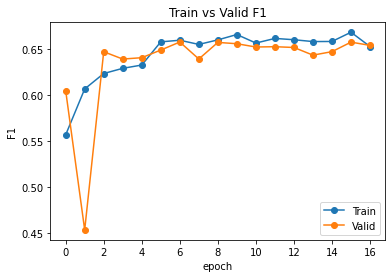

In [92]:
# inception attention seed 7 1e-3 maxpool
show_graph(train_f1_list, val_f1_list, epoch_list)

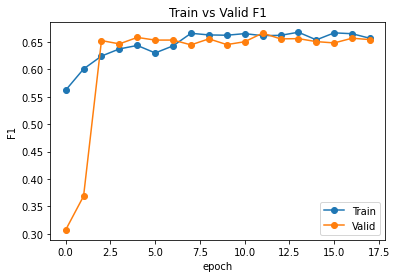

In [103]:
# inception attention seed 0 1e-3 maxpool
show_graph(train_f1_list, val_f1_list, epoch_list)

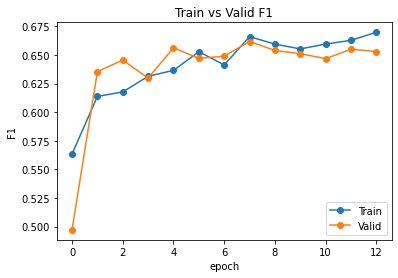

In [92]:
# inception attention seed 84 1e-3 maxpool
show_graph(train_f1_list, val_f1_list, epoch_list)

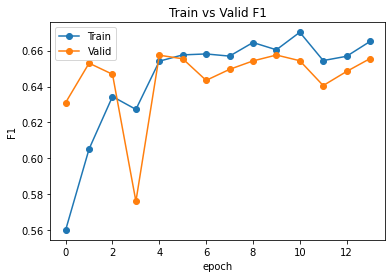

In [93]:
# inception attention seed 25 1e-3 maxpool
show_graph(train_f1_list, val_f1_list, epoch_list)

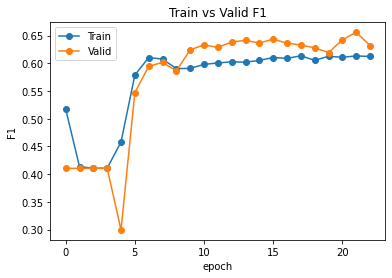

In [92]:
# inception attention seed 66 1e-3 maxpool
show_graph(train_f1_list, val_f1_list, epoch_list)

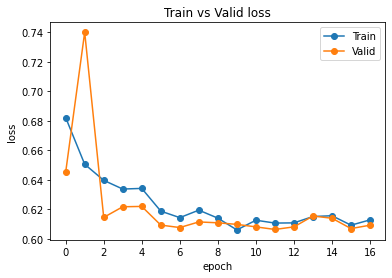

In [93]:
# inception attention seed 7 1e-3 maxpool
show_graph(train_loss_list, val_loss_list, epoch_list, 'loss')

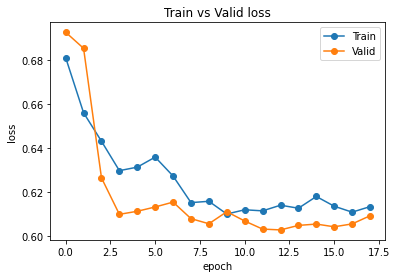

In [104]:
# inception attention seed 0 1e-3 maxpool
show_graph(train_loss_list, val_loss_list, epoch_list, 'loss')

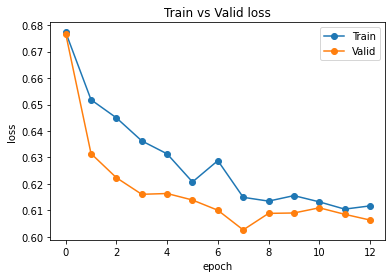

In [93]:
# inception attention seed 84 1e-3 maxpool
show_graph(train_loss_list, val_loss_list, epoch_list, 'loss')

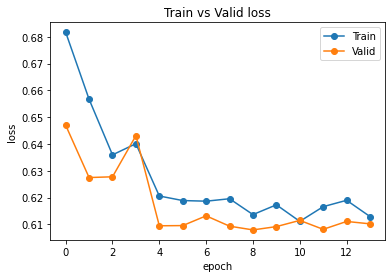

In [94]:
# inception attention seed 25 1e-3 maxpool
show_graph(train_loss_list, val_loss_list, epoch_list, 'loss')

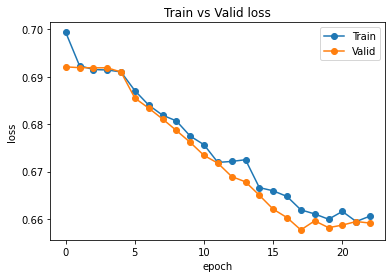

In [93]:
# inception attention seed 66 1e-3 maxpool
show_graph(train_loss_list, val_loss_list, epoch_list, 'loss')

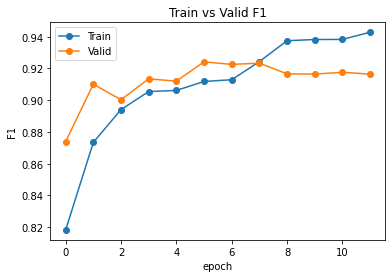

In [90]:
# freeze inception seed 25 1e-3 maxpool
show_graph(train_f1_list, val_f1_list, epoch_list)

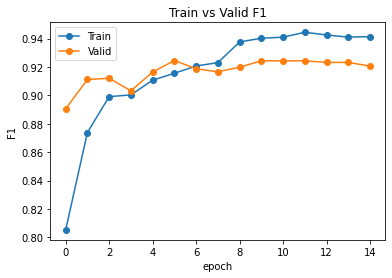

In [88]:
# freeze inception seed 84 1e-3
show_graph(train_f1_list, val_f1_list, epoch_list)

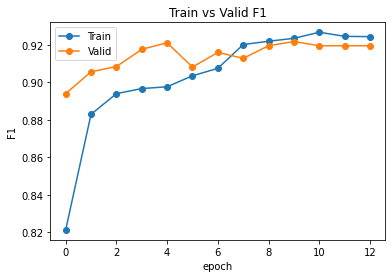

In [96]:
# freeze inception seed 84
show_graph(train_f1_list, val_f1_list, epoch_list)

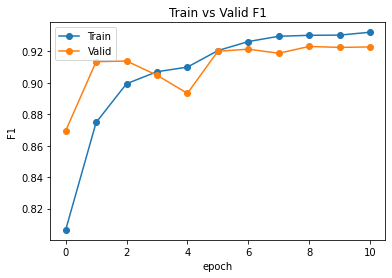

In [88]:
# freeze inception seed 25 1e-3
show_graph(train_f1_list, val_f1_list, epoch_list)

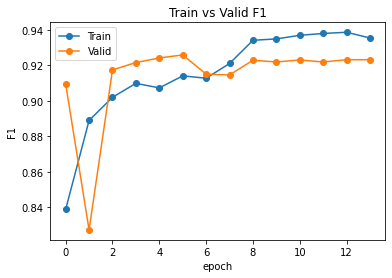

In [85]:
# freeze inception 66
show_graph(train_f1_list, val_f1_list, epoch_list)

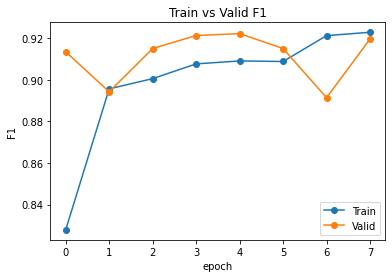

In [80]:
# freeze inception
show_graph(train_f1_list, val_f1_list, epoch_list)

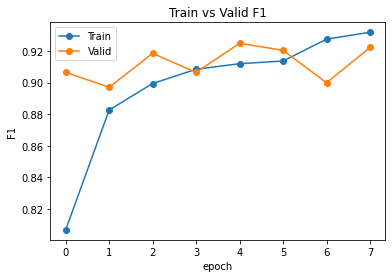

In [84]:
# freeze inception
show_graph(train_f1_list, val_f1_list, epoch_list)

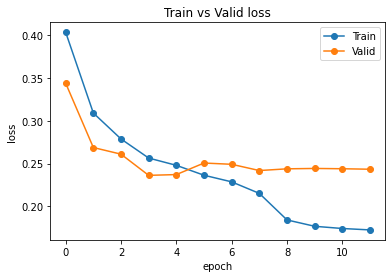

In [91]:
# freeze inception seed 25 1e-3 maxpool
show_graph(train_loss_list, val_loss_list, epoch_list, 'loss')

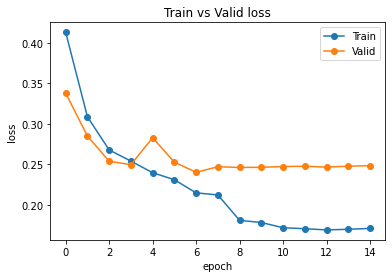

In [89]:
# freeze inception seed 84 1e-3
show_graph(train_loss_list, val_loss_list, epoch_list, 'loss')

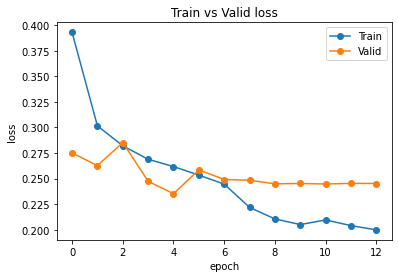

In [97]:
# freeze inception seed 84
show_graph(train_loss_list, val_loss_list, epoch_list, 'loss')

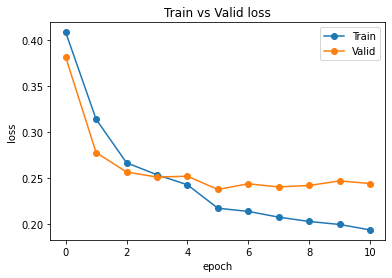

In [89]:
# freeze inception 25 1e-3
show_graph(train_loss_list, val_loss_list, epoch_list, 'loss')

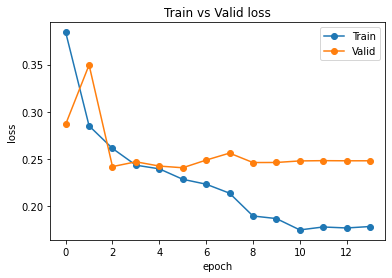

In [86]:
# freeze inception 66
show_graph(train_loss_list, val_loss_list, epoch_list, 'loss')

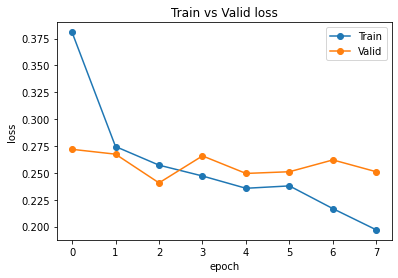

In [81]:
# freeze inception
show_graph(train_loss_list, val_loss_list, epoch_list, 'loss')

In [78]:
%load_ext tensorboard
%tensorboard --logdir=runs

In [93]:
import gc
del model 
gc.collect()

110

In [94]:
torch.cuda.empty_cache()

In [73]:
PATH = "my_checkpoint_incept_attention_seed_84_1e-3.pth.tar"
checkpoint = torch.load(PATH, map_location=device)
model = Inception()
model.load_state_dict(checkpoint['state_dict'])
model.to(device)
print(checkpoint['epoch'])

11


In [76]:
pred, score_preds, true = testing(model, dm)

test               precision    recall  f1-score   support

         0.0       0.54      0.62      0.58       302
         1.0       0.82      0.77      0.80       695

    accuracy                           0.72       997
   macro avg       0.68      0.70      0.69       997
weighted avg       0.74      0.72      0.73       997

test_ac 0.724172517552658
Confusion [[188 114]
 [161 534]]
Macro_f1 0.6864037570928738


In [102]:
t = dm.test_data.reset_index(drop=True)
t

,index,RevId,UserId,ResId,Comment,image_urls,score,label,preprocess_comment
0,4077,2521334,13201293,653281,Mình là khách quen của Loki cả trên Now và tại...,local1_folder-1/foody-loki-house-tao-pho-tra-s...,8.6,1,mình là khách quen của loki cả trên now và tại...
1,6448,2573475,14562049,890498,Mình đã gọi đây là một trong những quán cafe ...,local1_folder-1/foody-hoang-ha-bakery-coffee-5...,10.0,1,mình đã gọi đây là một trong những quán cafe đ...
2,4054,2895371,13967176,757432,Mình đã ăn rất nhiều lần và chỉ trung thành vớ...,local1_folder-1/foody-nem-nuong-nha-trang-co-h...,3.8,0,mình đã ăn rất nhiều lần và chỉ trung_thành vớ...
3,4280,3675043,15348110,649499,Cả nhà mình mua combo và thêm 4 cánh gà tổng h...,local1_folder-1/foody-pizza-hut-thai-thinh-758...,4.6,0,cả nhà mình mua combo và thêm 4 cánh_gà tổng h...
4,8947,6279731,1516967,791983,Thấy vắng nhưng đồ tươi nên mình ngồi ăn thử\n...,local1_folder-1/foody-xuan-seafood-hai-san-cac...,9.8,1,thấy vắng nhưng đồ tươi nên mình ngồi ăn thử n...
...,...,...,...,...,...,...,...,...,...
992,9729,3320053,9763313,954348,Check in luôn cho nóng hổi pà con ơi!ngon nhất...,local1_folder-1/foody-chu-beo-mi-y-mi-tron-onl...,10.0,1,check in luôn cho nóng_hổi pà con ơi ngon nhất...
993,1610,2055552,11034818,312332,"Mình đã ăn ở cá lăng thùy linh, món ăn rất ngo...",local1_folder-1/foody-ca-lang-thuy-linh-846-63...,10.0,1,mình đã ăn_ở cá_lăng thuỳ linh món ăn rất ngon...
994,3757,7626093,15768703,935465,"Ngon suất xắc luôn, 1 cốc to ú ụ, đóng gói cẩn...",local1_folder-1/foody-dong-duong-fruits-trai-c...,9.6,1,ngon suất xắc luôn 1 cốc to ú_ụ đóng_gói cẩn_t...
995,3288,13642297,23340870,1084759,Mình thấy quảng cáo bên thánh ăn. Có cái mâm ố...,local1_folder-1/foody-y-linh-oc-hai-san-duong-...,10.0,1,mình thấy quảng_cáo bên thánh ăn có cái mâm ốc...


In [104]:
t = dm.test_data.reset_index(drop=True)
t
t['pred'] = pred
wrong = t[t['pred'] != t['label']].reset_index()
wrong

,level_0,index,RevId,UserId,ResId,Comment,image_urls,score,label,preprocess_comment,pred
0,2,4054,2895371,13967176,757432,Mình đã ăn rất nhiều lần và chỉ trung thành vớ...,local1_folder-1/foody-nem-nuong-nha-trang-co-h...,3.8,0,mình đã ăn rất nhiều lần và chỉ trung_thành vớ...,1.0
1,6,7142,7080439,9657012,1001306,"Mình mua cả 3 loại bánh gà thường, phô mai và ...",local1_folder-1/foody-banh-ga-ba-ganh-ta-quang...,9.2,1,mình mua cả 3 loại bánh gà thường phô_mai và c...,0.0
2,7,8026,3232503,8098900,128472,Măm măm doner ngon nên hôm nay order thử cơm v...,local1_folder-1/foody-duc-long-doner-kebab-luo...,9.6,1,măm măm doner ngon nên hôm_nay order thử cơm v...,0.0
3,8,2142,8524400,1986427,255828,"gọi khản cổ lên mới có người đến order, nhân v...",local1_folder-1/foody-long-chan-chao-414-63737...,1.4,0,gọi khản cổ lên mới có người đến order nhân_vi...,1.0
4,18,9212,2553642,8793345,231313,Nếu ai biết chuyện của cô chắc chắn chả bao gi...,local1_folder-1/foody-chao-suon-co-la-959-6368...,4.6,0,nếu ai biết chuyện của cô chắc_chắn chả bao_gi...,1.0
...,...,...,...,...,...,...,...,...,...,...,...
270,965,6652,13643000,23300158,1000027642,Đây là địa điểm ăn thường xuyên của mình. Đồ ă...,local1_folder-1/foody-bep-me-yen-bun-bo-tron-n...,9.8,1,đây là địa_điểm ăn thường_xuyên của mình đồ_ăn...,0.0
271,967,5850,2201077,1089916,255551,Hnay quá lười ra đường nên lên Now đặt cơm Kom...,local1_folder-1/foody-kombo-com-nieu-singapore...,8.2,1,hnay quá lười ra đường nên lên now đặt cơm kom...,0.0
272,970,7953,4096458,19159028,754936,"Mình gọi 1 bát ốc to hấp, 150k mà nửa bát ốc l...",local1_folder-1/foody-oanh-oc-an-vat-cac-loai-...,2.6,0,mình gọi 1 bát ốc to hấp 150k mà nửa bát ốc là...,1.0
273,983,4489,2003443,8308405,629323,Em ăn bánh trứng gà non khá nhiều nơi nhưng nó...,local1_folder-1/foody-anh-bros-banh-trung-ga-n...,5.0,0,em ăn bánh trứng gà non khá nhiều nơi nhưng nó...,1.0


In [108]:
wrong.iloc[273]['preprocess_comment']

'em ăn bánh trứng gà non khá nhiều nơi nhưng nói thật em không hài_lòng cho lắm với bánh trứng gà non ở quán này cho lắm hôm em đặt về ăn là lúc em như một con ma đói mà những lúc đói thì người_ta hay bảo dù đồ có chán thì ăn cũng thấy ngon nhưng thề là em ăn thấy chẳng ngon_miệng gì cả pải nói thế_nào nhờ bột dầy không được xốp không thơm ngậy và bánh của em nướng còn bị cháy cơ em là đứa hơi kĩ_tính nên chắc là sẽ không có lần thứ hai em ăn_ở quán này nữa'

In [75]:
optimizer = torch.optim.Adam([
        {'params': model.BERT.lstm.parameters()},  
        {'params': model.incept.flat.parameters()}, 
        {'params': model.incept.avgpool.parameters()},  
        {'params': model.dense.parameters()},       
        {'params': model.cl.parameters()},       
        {'params': model.BERT.PhoBERT.parameters(), 'lr': 1e-5},
        {'params': model.incept.incept.parameters(), 'lr': 1e-5}
    ], lr=1e-3)
optimizer.load_state_dict(checkpoint['optimizer'])

In [ ]:
import cv2
def plot(model):
  model.eval()
  test_preds = torch.tensor([], device=device)
  test_labels = torch.tensor([], device = device)
  test_text = []
  test_img = []

  soft_m = nn.Softmax(dim=-1)
  with torch.no_grad():
    for i, (texts, images, labels) in enumerate(dm.test_dataloader()):
        labels = labels.to(device)

        outputs = model(images, texts)

        output_scores = soft_m(outputs)
        predictions = torch.argmax(output_scores, dim=-1)

        test_preds = torch.cat((test_preds, predictions), dim=0)
        test_labels = torch.cat((test_labels, labels), dim=0)
        for t in texts:
          test_text.append(t) 
        for i in images:
          test_img.append(i) 

    
    test_preds = test_preds.cpu().numpy()
    test_labels = test_labels.cpu().numpy()
  i = 1
  plt.figure(figsize=(40,40))
  print(len(test_labels))
  for image, actual_label, label, text in zip(test_img, test_labels, test_preds, test_text):

      if (actual_label == label):

        plt.subplot(4,4,i)
        i+=1
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = T.ToPILImage()(image).convert("RGB")
        plt.imshow(image)
        plt.axis('off')
        plt.title("Text: {}...\n Actual: {}\n Predicted: {}".format(text[:30], actual_label, label))
        # plt.xlabel(text)
      else:
        pass
      if (i==17):
        break;
  plt.savefig('res_freeze_af20epoch.png', bbox_inches='tight')
  plt.show()
  

plot(model)


In [98]:
torch.cuda.empty_cache()

In [96]:
!nvidia-smi

Fri Apr 22 09:11:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:5E:00.0 Off |                  N/A |
| 66%   74C    P2   198W / 250W |  10884MiB / 11019MiB |     81%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:86:00.0 Off |                  N/A |
| 57%   

# Multimodal

In [ ]:
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score

class Multimodal(pl.LightningModule):
  def __init__(self, lr_multi, lr_classifier):
    super(Multimodal,self).__init__()
    self.loss_module = nn.CrossEntropyLoss()
    self.BERT = Bert_Lstm()
    self.incept = Inception()
    self.dense = nn.Linear(256,256)
    self.cl = nn.Linear(256,3)
    self.bpe_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/bpe.codes"
    self.vocab_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/dict.txt"
    self.lr_multi = lr_multi
    self.lr_classifier = lr_classifier

    # self.model = self._build_model()
    # self.trainer_params = self._get_trainer_params()

  def forward(self, image, texts, labels=None):
    inputs = tokenize_data(texts, self.vocab_path, self.bpe_path)
    # b_labels = None
    # b_labels = labels.to(self.device)

    for key in inputs:
        inputs[key] = inputs[key].to(self.device)
    image = image.to(self.device)

    fea1 = self.BERT(inputs)
    fea2 = self.incept(image)
    cat = torch.cat((fea1, fea2), 1)
    out = self.cl(cat)

    return out
  
  def configure_optimizers(self):
    roberta_params = self.BERT.parameters()
    inception_params = self.incept.parameters()
    dense_params = self.dense.parameters()
    classifier_params = self.cl.parameters()

    # for n,p in classifier_params:
    #   print(n,p)

    # grouped_params = [
    #     {"params": roberta_params, "lr": self.lr_multi},
    #     {"params": inception_params, "lr": self.lr_multi},
    #     {"params": dense_params, "lr": self.lr_multi},
    #     {"params": classifier_params, "lr": self.lr_classifier}
    # ]
    # optimizer = torch.optim.AdamW(
    #     grouped_params
    # )
    optimizer = torch.optim.AdamW(
              self.parameters(), 
              lr = 0.001
          )

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.98)
  


  def training_step(self, batch, batch_idx):
    texts, images, labels = batch
    preds = self(images, texts, labels)
    labels = labels.to(self.device)

    loss = self.loss_module(preds, labels)

    return loss
  
  def validation_step(self, batch, batch_idx):
    texts, images, labels = batch
    logits = self(images, texts, labels)

    loss = self.loss_module(logits, labels)
    output_scores = torch.softmax(logits, dim=-1)

    return loss, output_scores, labels

  def validation_epoch_end(self, validation_step_outputs):
    val_preds = torch.tensor([], device=self.device)
    val_scores = torch.tensor([], device=self.device)
    val_labels = torch.tensor([], device=self.device)
    val_loss = 0
    total_item = 0

    for idx, item in enumerate(validation_step_outputs):
        loss, output_scores, labels = item

        predictions = torch.argmax(output_scores, dim=-1)
        val_preds = torch.cat((val_preds, predictions), dim=0)
        val_scores = torch.cat((val_scores, output_scores[:, 1]), dim=0)
        val_labels = torch.cat((val_labels, labels), dim=0)

        val_loss += loss
        total_item += 1

    # print("VAL PREDS", val_preds.shape)
    # print("VAL SCORES", val_scores.shape)
    # print("VAL LABELS", val_labels.shape)
    val_preds = val_preds.cpu().numpy()
    val_scores = val_scores.cpu().numpy()
    val_labels = val_labels.cpu().numpy()

    # reports = classification_report(val_labels, val_preds, output_dict=True)
    print("VAL PREDS", val_preds)
    print("VAL LABELS", val_labels)
    print("VAL SCORES", val_scores)
    # try:
    #     auc = roc_auc_score(val_labels, val_scores)
    # except Exception as e:
    #     print(e)
    #     print("Cannot calculate AUC. Default to 0")
    #     auc = 0
    accuracy = accuracy_score(val_labels, val_preds)

    print(classification_report(val_labels, val_preds))

    self.log("loss/val", val_loss)
    # self.log("auc/val", auc)
    self.log("accuracy/val", accuracy)
    # self.log("precision/val", reports["weighted avg"]["precision"])
    # self.log("recall/val", reports["weighted avg"]["recall"])
    # self.log("f1/val", reports["weighted avg"]["f1-score"])




In [ ]:
# trainer = pl.Trainer(
#     fast_dev_run=True,
# )
# multi = Multimodal(lr_multi=1e-5, lr_classifier=3e-3)
# dm = SentimentDataModule(data_df)
# trainer.fit(multi, dm)


In [ ]:
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

torch.manual_seed(123)

tb_logger = pl_loggers.TensorBoardLogger('/content/drive/MyDrive/Colab Notebooks/Multimodal/tb_logs/')

trainer = pl.Trainer(
    min_epochs=1,
    max_epochs=5,
    gpus=1,
    precision=16,
    val_check_interval=0.5,
    # check_val_every_n_epoch=1,
    callbacks=[
      ModelCheckpoint(
          dirpath='/content/drive/MyDrive/Colab Notebooks/Multimodal/ckpt',
          save_top_k=3,
          monitor='f1/val',
      ), 
      EarlyStopping('f1/val', patience=5)
    ],
    fast_dev_run=False,
    logger=tb_logger
)

dm.setup(stage="fit")
trainer.fit(multi, dm)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/optimizers.py:39: UserWarning: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
  UserWarning,
Missing logger folder: /content/drive/MyDrive/Colab Notebooks/Multimodal/tb_logs/default

  | Name        | Type             | Params
-------------------------------------------------
0 | loss_module | CrossEntropyLoss | 0     
1 | BERT        | Bert_Lstm        

Validation sanity check: 0it [00:00, ?it/s]

VAL PREDS [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 0. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 1. 2. 2. 2. 2.]
VAL LABELS [1. 2. 0. 0. 2. 2. 2. 2. 0. 2. 1. 0. 1. 1. 1. 1. 0. 2. 2. 1. 2. 1. 1. 2.
 1. 2. 2. 2. 1. 2. 0. 1.]
VAL SCORES [0.2503872  0.25511816 0.33502465 0.233994   0.2737939  0.30235466
 0.30597535 0.28478307 0.34449401 0.28433585 0.3386114  0.24622746
 0.2953767  0.28849763 0.32898384 0.27177638 0.2833459  0.30263612
 0.31047884 0.24584286 0.32877764 0.25412712 0.20685947 0.29209316
 0.30371505 0.292875   0.31025544 0.36505568 0.30896547 0.29549003
 0.30231565 0.30986333]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         6
         1.0       0.50      0.08      0.14        12
         2.0       0.41      0.86      0.56        14

    accuracy                           0.41        32
   macro avg       0.30      0.31      0.23        32
weighted avg       0.37      0.41      0.30        32



Training: 0it [00:00, ?it/s]

AssertionError: ignored

In [ ]:
# multi

In [ ]:
# from sklearn.metrics import roc_auc_score, classification_report, accuracy_score


# class Concatmodal(nn.Module):
#   def __init__(self, lr_multi, lr_classifier):
#     super(Concatmodal,self).__init__()
#     self.loss_module = nn.CrossEntropyLoss()
#     self.BERT = Bert_Lstm()
#     self.incept = Inception()
#     self.dense = nn.Linear(256,256)
#     self.cl = nn.Linear(256,3)
#     self.bpe_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/bpe.codes"
#     self.vocab_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/dict.txt"
#     self.lr_multi = lr_multi
#     self.lr_classifier = lr_classifier
  
#   def forward(self, image, texts, labels=None):
#     inputs = tokenize_data(texts, self.vocab_path, self.bpe_path)
#     # b_labels = None
#     # b_labels = labels.to(self.device)

#     for key in inputs:
#         inputs[key] = inputs[key].to(self.device)
#     image = image.to(self.device)

#     fea1 = self.BERT(inputs)
#     fea2 = self.incept(image)
#     cat = torch.cat((fea1, fea2), 1)
#     out = self.cl(cat)

#     return out
  

# class Multimodal(pl.LightningModule):
#   def __init__(self, lr_multi, lr_classifier):
#     super(Multimodal,self).__init__()
#     # self.loss_module = nn.CrossEntropyLoss()
#     # self.BERT = Bert_Lstm()
#     # self.incept = Inception()
#     # self.dense = nn.Linear(256,256)
#     # self.cl = nn.Linear(256,3)
#     # self.bpe_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/bpe.codes"
#     # self.vocab_path = "/content/drive/MyDrive/NLP/PhoBERT_base_transformers/dict.txt"
#     self.lr_multi = lr_multi
#     self.lr_classifier = lr_classifier

#     self.model = self._build_model()
#     # self.trainer_params = self._get_trainer_params()

#   def forward(self, image, texts, labels=None):
#     # inputs = tokenize_data(texts, self.vocab_path, self.bpe_path)
#     # # b_labels = None
#     # # b_labels = labels.to(self.device)

#     # for key in inputs:
#     #     inputs[key] = inputs[key].to(self.device)
#     # image = image.to(self.device)

#     # fea1 = self.BERT(inputs)
#     # fea2 = self.incept(image)
#     # cat = torch.cat((fea1, fea2), 1)
#     # out = self.model(cat)

#     return self.model(image, texts)
  
#   def _build_model(self):
#     return Concatmodal(self.lr_multi, self.lr_classifier)
  
#   def configure_optimizers(self):
#     # roberta_params = self.BERT.parameters()
#     # inception_params = self.incept.parameters()
#     # dense_params = self.dense.parameters()
#     # classifier_params = self.cl.parameters()

#     # for n,p in classifier_params:
#     #   print(n,p)

#     # grouped_params = [
#     #     {"params": roberta_params, "lr": self.lr_multi},
#     #     {"params": inception_params, "lr": self.lr_multi},
#     #     {"params": dense_params, "lr": self.lr_multi},
#     #     {"params": classifier_params, "lr": self.lr_classifier}
#     # ]
#     # optimizer = torch.optim.AdamW(
#     #     grouped_params
#     # )
#     optimizer = torch.optim.AdamW(
#               self.model.parameters(), 
#               lr = 0.001
#           )

#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.98)
  


#   def training_step(self, batch, batch_idx):
#     texts, images, labels = batch
#     preds = self(images, texts, labels)

#     loss = self.loss_module(preds, labels)

#     print("train_loss", loss)
#     return loss
  
#   def validation_step(self, batch, batch_idx):
#     texts, images, labels = batch
#     logits = self(images, texts, labels)

#     loss = self.loss_module(logits, labels)
#     output_scores = torch.softmax(logits, dim=-1)

#     return loss, output_scores, labels

#   def validation_epoch_end(self, validation_step_outputs):
#     val_preds = torch.tensor([], device=self.device)
#     val_scores = torch.tensor([], device=self.device)
#     val_labels = torch.tensor([], device=self.device)
#     val_loss = 0
#     total_item = 0

#     for idx, item in enumerate(validation_step_outputs):
#         loss, output_scores, labels = item

#         predictions = torch.argmax(output_scores, dim=-1)
#         val_preds = torch.cat((val_preds, predictions), dim=0)
#         val_scores = torch.cat((val_scores, output_scores[:, 1]), dim=0)
#         val_labels = torch.cat((val_labels, labels), dim=0)

#         val_loss += loss
#         total_item += 1

#     # print("VAL PREDS", val_preds.shape)
#     # print("VAL SCORES", val_scores.shape)
#     # print("VAL LABELS", val_labels.shape)
#     val_preds = val_preds.cpu().numpy()
#     val_scores = val_scores.cpu().numpy()
#     val_labels = val_labels.cpu().numpy()

#     # reports = classification_report(val_labels, val_preds, output_dict=True)
#     print("VAL PREDS", val_preds)
#     print("VAL LABELS", val_labels)
#     print("VAL SCORES", val_scores)
#     # try:
#     #     auc = roc_auc_score(val_labels, val_scores)
#     # except Exception as e:
#     #     print(e)
#     #     print("Cannot calculate AUC. Default to 0")
#     #     auc = 0
#     accuracy = accuracy_score(val_labels, val_preds)

#     print(classification_report(val_labels, val_preds))

#     self.log("loss/val", val_loss)
#     # self.log("auc/val", auc)
#     self.log("accuracy/val", accuracy)
#     # self.log("precision/val", reports["weighted avg"]["precision"])
#     # self.log("recall/val", reports["weighted avg"]["recall"])
#     # self.log("f1/val", reports["weighted avg"]["f1-score"])


